In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline

In [22]:
import matplotlib as mpl

In [23]:
import vehicleDetection

In [24]:
from vehicleDetection.temporal import *

# Load and look at the training data.

In [89]:
images, classes = vehicleDetection.data.getData(numLighter=0, numFlip=0)
imageWindows = images
windowClasses = classes

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

# Train the classifier on the full dataset with the best classifier parameters.

In [90]:
detectorNoAug = vehicleDetection.detector.Detector(clfParameters=dict(C=1, gamma=7e-5))

Got scalar parameter (gamma). Assuming no CV requested.


In [91]:
# indices = np.arange(len(images))
# np.random.shuffle(indices)
# # Fit time here is roughly linear in n.
# n = 1024
# imageWindows = [images[i] for i in indices[:n]]
# windowClasses = [classes[i] for i in indices[:n]]

In [92]:
spi = (3*60 + 59) / (6053 + 673)
print('Estimated fit/test runtime is %.3g minutes.' % (len(imageWindows) * spi / 60.,))

Estimated fit/test runtime is 3.98 minutes.


In [93]:
%%time
detectorNoAug.fit(
    imageWindows,
    windowClasses,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6053-image train accuracy of clf =  0.99966958533
673-image test accuracy of clf =  0.994056463596
CPU times: user 2min 46s, sys: 5.01 s, total: 2min 51s
Wall time: 3min 35s


# Run the detector on a test image.

In [94]:
maxf = 256
testh = HeatVideo(maxFrames=maxf)
projh = HeatVideo(fpath='../../../data/vehicleDetection/project_video.mp4', maxFrames=maxf)

In [95]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [96]:
18653038 / 3726991, 18653038 / 8512356, 18653038 / 4581250

(5.0048519033182535, 2.1912896970004545, 4.071604474761255)

In [78]:
# from IPython.core.debugger import set_trace; set_trace()
%lprun -f detectorNoAug.search_windows testh.go(detectorNoAug);

Number of support vectors for each class: [209 195]


HBox(children=(IntProgress(value=0, description='processing: ', max=38), HTML(value='')))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Timer unit: 1e-06 s

Total time: 224.196 s
File: /mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/detector.py
Function: search_windows at line 196

Line #      Hits         Time  Per Hit   % Time  Line Contents
   196                                               def search_windows(self, img, windows):
   197                                                   #1) Create an empty list to receive positive detection windows
   198        38           86      2.3      0.0          on_windows = []
   199                                           
   200                                                   #2) Iterate over all windows in the list
   201     22344        31641      1.4      0.0          for window in windows:
   202                                           
   203                                                       #3) Extract the test window from original image
   204     22306      1257798     56.4      0.6              test_img = cv2.resize(img[window[0][1]:w

In [84]:
testh.persist(16)

HBox(children=(IntProgress(value=0, description='persist bboxes: ', max=38), HTML(value='')))

In [85]:
# from importlib import reload
# reload(vehicleDetection.drawing)

In [86]:
%%time
testh.video();

HBox(children=(IntProgress(value=1, bar_style='info', description='test_video-detected.mp4: ', max=1), HTML(value='')))

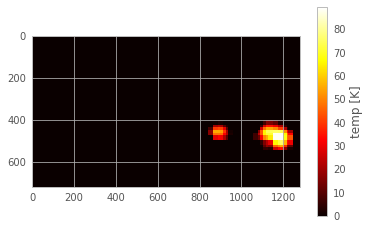

In [87]:
T = testh.temperatures[-1]
fig, ax = plt.subplots()
im = ax.imshow(T, origin='upper', cmap='hot')
fig.colorbar(im, label='temp [K]')

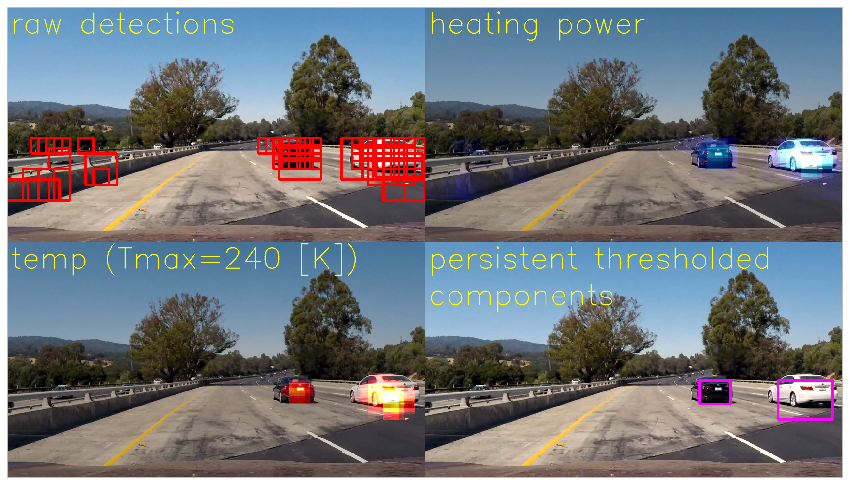

In [88]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(testh.vidFrame)
ax.set_xticks([])
ax.set_yticks([]);

In [ ]:
break

In [ ]:
projh.go(detectorNoAug);

In [ ]:
projh.persist(20)

In [ ]:
projh.video();

In [ ]:
break

Try again on the agumented data.

In [ ]:
images, classes = vehicleDetection.data.getData()

In [ ]:
detectorAug = vehicleDetection.detector.Detector()

In [ ]:
%%time
detectorAug.fit(
    images,
    classes,
)

In [ ]:
testha = HeatVideo()
testha.go(detectorAug, label='-augmented')

In [ ]:
projha = HeatVideo(fpath='../../../data/vehicleDetection/project_video.mp4',)
projha.go(detectorAug, label='-augmented')